# Data Preparation
## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns

# estas son las clases para sustitutición con sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
# dividir dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

# one hot encoding con feature-engine
#from feature_engine.encoding import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# GroupKFold en un pipeline con StandardScaler y SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

## Import Data

In [2]:
df = pd.read_excel("../datasets/raw/BBDD_Hospitalizacion.xlsx", sheet_name="Datos", engine="openpyxl")

c:\Users\ozi\ti\evstack\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
print(df.shape)

(568, 20)


## Pre-Processing Data

In [4]:
#df.info()
#df.columns
def limpiar_nombres_columnas(df):
    # Función para limpiar y formatear los nombres de las columnas
    def limpiar_nombre(nombre):
        # Eliminar caracteres especiales y espacios
        nombre = re.sub(r'\W+', '_', nombre)
        # Eliminar acentos
        nombre = unidecode(nombre)
        # Convertir a minúsculas
        nombre = nombre.lower()
        return nombre
    
    df.columns = [limpiar_nombre(col) for col in df.columns]

limpiar_nombres_columnas(df)
df.columns

In [5]:
df.rename(columns={'numero_de_dias_post_biopsia_en_que_se_presenta_la_complicacion_infecciosa': 'n_post_biopsia'}, inplace=True)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df.columns

Index(['edad', 'diabetes', 'hospitalizacion_ultimo_mes', 'psa',
       'biopsias_previas', 'volumen_prostatico',
       'antibiotico_utiliazado_en_la_profilaxis', 'numero_de_muestras_tomadas',
       'cup', 'enf_cronica_pulmonar_obstructiva', 'biopsia', 'n_post_biopsia',
       'fiebre', 'itu', 'tipo_de_cultivo', 'agente_aislado',
       'patron_de_resistencia', 'hospitalizacion', 'dias_hospitalizacion_mq',
       'dias_hospitalizacion_upc'],
      dtype='object')

In [ ]:
df.biopsia.unique()

In [ ]:
df.head()

##### Pre-Processing Ordinal, Nominal, Numeric Variables

1. **Variables Ordinales:**
    - **DIABETES:** Parece ser una variable binaria (SÍ/NO). 
    - **HOSPITALIZACIÓN ULTIMO MES:** Parece ser una variable numérica, pero dado que representa el número de hospitalizaciones en el último mes, podría tratarse como ordinal. Podrías aplicar Label Encoding si hay un orden lógico.
    - **CUP (Número de copas):** Si este representa un número discreto de copas, podrías tratarlo como ordinal y aplicar Label Encoding.

2. **Variables Nominales:**
    - **ANTIBIOTICO UTILIZADO EN LA PROFILAXIS:** Dado que hay diferentes antibióticos, esta variable parece ser nominal. Deberías aplicar One-Hot Encoding.
    - **TIPO DE CULTIVO:** Si hay diferentes tipos de cultivos, deberías aplicar One-Hot Encoding.
    - **AGENTE AISLADO:** Dado que hay diferentes agentes aislados, esta variable parece ser nominal. Deberías aplicar One-Hot Encoding.
    - **PATRÓN DE RESISTENCIA:** Dado que hay diferentes patrones de resistencia, esta variable parece ser nominal. Deberías aplicar One-Hot Encoding.

3. **Variables numéricas:**
    - **EDAD, PSA, VOLUMEN PROSTÁTICO, NUMERO DE MUESTRAS TOMADAS, NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA, DIAS HOSPITALIZACION MQ, DIAS HOSPITALIZACIÓN UPC:** Estas parecen ser variables numéricas y puedes tratarlas utilizando la normalización estándar.

In [ ]:
df.biopsia.nunique()

In [6]:
# Crear un transformador personalizado para aplicar LabelEncoder a múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        return X

# Obtener las columnas numéricas y categóricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
ordinal_var = ['diabetes', 'hospitalizacion_ultimo_mes', 'cup', 'biopsia']
categorical_columns = df.select_dtypes(include=['object']).columns

# Convertir las columnas categóricas a tipo str
df[categorical_columns] = df[categorical_columns].astype(str)

# Definir las transformaciones para las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Definir las transformaciones para las columnas ordinales
ordinal_transformer = MultiColumnLabelEncoder(columns=ordinal_var)

# Definir las transformaciones para las columnas categóricas restantes
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear la columna transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('ord', ordinal_transformer, ordinal_var),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Crear la pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar la pipeline al DataFrame
transformed_df = pipeline.fit_transform(df)

# Obtener las columnas numéricas y categóricas después de la transformación
numeric_columns_transformed = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=numeric_columns)
ordinal_columns_transformed = ordinal_transformer.columns  # Obtener las columnas transformadas directamente de MultiColumnLabelEncoder
categorical_columns_transformed = pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['onehot'].get_feature_names_out(input_features=categorical_columns)

# Unir los nombres de las columnas numéricas, ordinales y categóricas después de la transformación
all_columns_transformed = np.concatenate([numeric_columns_transformed, ordinal_columns_transformed, categorical_columns_transformed])

# Convertir el array transformado a un DataFrame con los nuevos nombres de columnas
transformed_df2 = pd.DataFrame(transformed_df, columns=all_columns_transformed)



In [7]:
pd.set_option('display.max_columns', None)

In [8]:
transformed_df2.head(10)

,edad,psa,numero_de_muestras_tomadas,dias_hospitalizacion_mq,dias_hospitalizacion_upc,diabetes,hospitalizacion_ultimo_mes,cup,biopsia,diabetes_NO,diabetes_SI,hospitalizacion_ultimo_mes_NO,hospitalizacion_ultimo_mes_SI,biopsias_previas_NO,biopsias_previas_SI,biopsias_previas_nan,volumen_prostatico_NO,volumen_prostatico_SI,volumen_prostatico_nan,antibiotico_utiliazado_en_la_profilaxis_CEFALOSPORINA_AMINOGLUCOCIDO,antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICOSIDO,antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICÓSIDO,antibiotico_utiliazado_en_la_profilaxis_OROQUINOLONAS,antibiotico_utiliazado_en_la_profilaxis_OTROS,cup_NO,cup_SI,cup_nan,enf_cronica_pulmonar_obstructiva_NO,enf_cronica_pulmonar_obstructiva_SI,"enf_cronica_pulmonar_obstructiva_SI, ASMA","enf_cronica_pulmonar_obstructiva_SI, EPOC",enf_cronica_pulmonar_obstructiva_nan,biopsia_ADENOCARCINOMA GLEASON 10,biopsia_ADENOCARCINOMA GLEASON 6,biopsia_ADENOCARCINOMA GLEASON 7,biopsia_ADENOCARCINOMA GLEASON 8,biopsia_ADENOCARCINOMA GLEASON 9,biopsia_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS,biopsia_HIPERPLASIA PROSTATICA,biopsia_NEG,biopsia_PROSTATITIS,n_post_biopsia_NO,n_post_biopsia_nan,fiebre_NO,fiebre_SI,itu_NO,itu_SI,tipo_de_cultivo_HEMOCULTIVO,tipo_de_cultivo_HEMOCULTIVO Y UROCULTIVO,tipo_de_cultivo_NO,tipo_de_cultivo_UROCULTIVO,agente_aislado_E.COLI,agente_aislado_NO,agente_aislado_PSEUDOMONAS AERUGINOSA,agente_aislado_nan,"patron_de_resistencia_AMPI R, CIPRO R, GENTA R, SULFA M R",patron_de_resistencia_MULTI SENSIBLE,patron_de_resistencia_NO,"patron_de_resistencia_RESISTENTE A AMPI, CIPRO Y GENTA","patron_de_resistencia_RESISTENTE A AMPI, SULFA, CEFADROXILO, CEFUROXIMO, CIPRO Y CEFEPIME, CEFOTAXIMA",hospitalizacion_NO,hospitalizacion_SI,hospitalizacion_nan
0,-1.173476,-0.594326,-0.254351,1.916491,-0.071750,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.849968,-0.357145,-0.254351,5.050560,-0.071750,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.742132,1.008253,2.808650,4.005870,15.210915,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.849968,-0.402017,-0.254351,5.050560,-0.071750,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.957804,1.008253,2.808650,4.005870,15.210915,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,-0.957804,-0.594326,-0.254351,2.961180,-0.071750,1.0,1.0,0.0,7.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,-1.173476,-0.402017,-0.254351,2.961180,-0.071750,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0.336228,-0.453299,-0.254351,1.916491,-0.071750,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0

In [9]:
transformed_df2.columns

Index(['edad', 'psa', 'numero_de_muestras_tomadas', 'dias_hospitalizacion_mq',
       'dias_hospitalizacion_upc', 'diabetes', 'hospitalizacion_ultimo_mes',
       'cup', 'biopsia', 'diabetes_NO', 'diabetes_SI',
       'hospitalizacion_ultimo_mes_NO', 'hospitalizacion_ultimo_mes_SI',
       'biopsias_previas_NO', 'biopsias_previas_SI', 'biopsias_previas_nan',
       'volumen_prostatico_NO', 'volumen_prostatico_SI',
       'volumen_prostatico_nan',
       'antibiotico_utiliazado_en_la_profilaxis_CEFALOSPORINA_AMINOGLUCOCIDO',
       'antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICOSIDO',
       'antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICÓSIDO',
       'antibiotico_utiliazado_en_la_profilaxis_OROQUINOLONAS',
       'antibiotico_utiliazado_en_la_profilaxis_OTROS', 'cup_NO', 'cup_SI',
       'cup_nan', 'enf_cronica_pulmonar_obstructiva_NO',
       'enf_cronica_pulmonar_obstructiva_SI',
       'enf_cronica_pulmonar_obstructiva_SI, ASMA',
       'enf_c

In [10]:
# Seleccionar las columnas relacionadas con la variable objetivo "biopsia"
biopsia_columns = ['biopsia_ADENOCARCINOMA GLEASON 10', 'biopsia_ADENOCARCINOMA GLEASON 6',
                   'biopsia_ADENOCARCINOMA GLEASON 7', 'biopsia_ADENOCARCINOMA GLEASON 8',
                   'biopsia_ADENOCARCINOMA GLEASON 9',
                   'biopsia_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS',
                   'biopsia_HIPERPLASIA PROSTATICA', 'biopsia_NEG', 'biopsia_PROSTATITIS']


# Seleccionar el resto de las columnas (variables predictoras)
X = transformed_df2.drop(columns=['biopsia'] + biopsia_columns)

# Definir la variable objetivo "biopsia" codificada
y = transformed_df2['biopsia']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of training sets:
X_train: (454, 53)
y_train: (454,)

Shapes of testing sets:
X_test: (114, 53)
y_test: (114,)


In [19]:
filename = '../datasets/processed/'
X_train.to_csv(filename + 'X_train.csv', sep=',', index=False)
y_train.to_csv(filename + 'y_train.csv', sep=',', index=False)
X_test.to_csv(filename + 'X_test.csv', sep=',', index=False)
y_test.to_csv(filename + 'y_test.csv', sep=',', index=False)

In [11]:
y_train.head()

248    8.0
88     7.0
334    2.0
362    2.0
33     2.0
Name: biopsia, dtype: float64

In [12]:
X_train.columns

Index(['edad', 'psa', 'numero_de_muestras_tomadas', 'dias_hospitalizacion_mq',
       'dias_hospitalizacion_upc', 'diabetes', 'hospitalizacion_ultimo_mes',
       'cup', 'diabetes_NO', 'diabetes_SI', 'hospitalizacion_ultimo_mes_NO',
       'hospitalizacion_ultimo_mes_SI', 'biopsias_previas_NO',
       'biopsias_previas_SI', 'biopsias_previas_nan', 'volumen_prostatico_NO',
       'volumen_prostatico_SI', 'volumen_prostatico_nan',
       'antibiotico_utiliazado_en_la_profilaxis_CEFALOSPORINA_AMINOGLUCOCIDO',
       'antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICOSIDO',
       'antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICÓSIDO',
       'antibiotico_utiliazado_en_la_profilaxis_OROQUINOLONAS',
       'antibiotico_utiliazado_en_la_profilaxis_OTROS', 'cup_NO', 'cup_SI',
       'cup_nan', 'enf_cronica_pulmonar_obstructiva_NO',
       'enf_cronica_pulmonar_obstructiva_SI',
       'enf_cronica_pulmonar_obstructiva_SI, ASMA',
       'enf_cronica_pulmonar_ob

In [14]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Crear el modelo de RandomForestClassifier
model = RandomForestClassifier()

# Inicializar el RFE con el modelo
rfe = RFE(estimator=model, n_features_to_select=10)  # Ajusta este número según tus necesidades

# Ajustar el RFE al conjunto de entrenamiento
rfe = rfe.fit(X_train, y_train)

# Obtener las columnas seleccionadas
selected_columns = X_train.columns[rfe.support_]

# Visualizar las características seleccionadas
print("Características seleccionadas:")
print(selected_columns)

# Entrenar el modelo solo con las características seleccionadas
X_train_selected = rfe.transform(X_train)
model.fit(X_train_selected, y_train)


Características seleccionadas:
Index(['edad', 'psa', 'numero_de_muestras_tomadas', 'diabetes_SI',
       'biopsias_previas_SI', 'volumen_prostatico_NO',
       'antibiotico_utiliazado_en_la_profilaxis_CEFALOSPORINA_AMINOGLUCOCIDO',
       'antibiotico_utiliazado_en_la_profilaxis_FLUOROQUINOLONA_AMINOGLICOSIDO',
       'enf_cronica_pulmonar_obstructiva_NO', 'fiebre_SI'],
      dtype='object')


RandomForestClassifier()

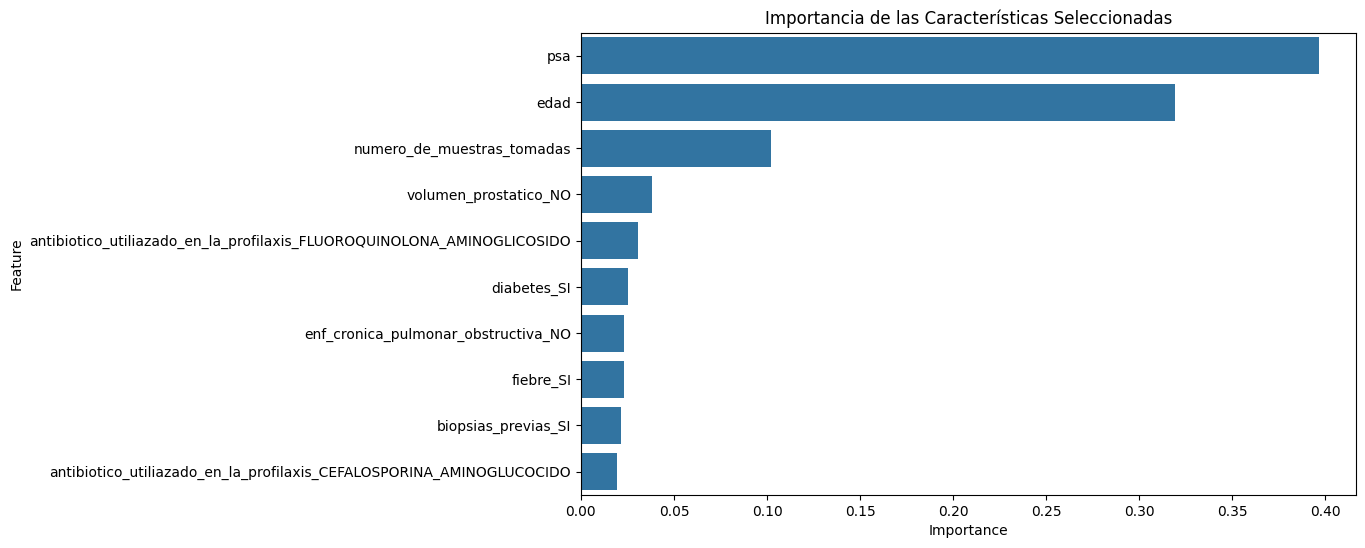

In [15]:
# Obtener la importancia de las características seleccionadas
feature_importance_selected = model.feature_importances_

# Crear un DataFrame con las características seleccionadas y su importancia
feature_importance_selected_df = pd.DataFrame({'Feature': selected_columns, 'Importance': feature_importance_selected})

# Ordenar por importancia descendente
feature_importance_selected_df = feature_importance_selected_df.sort_values(by='Importance', ascending=False)

# Visualizar las características seleccionadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_selected_df)
plt.title('Importancia de las Características Seleccionadas')
plt.show()

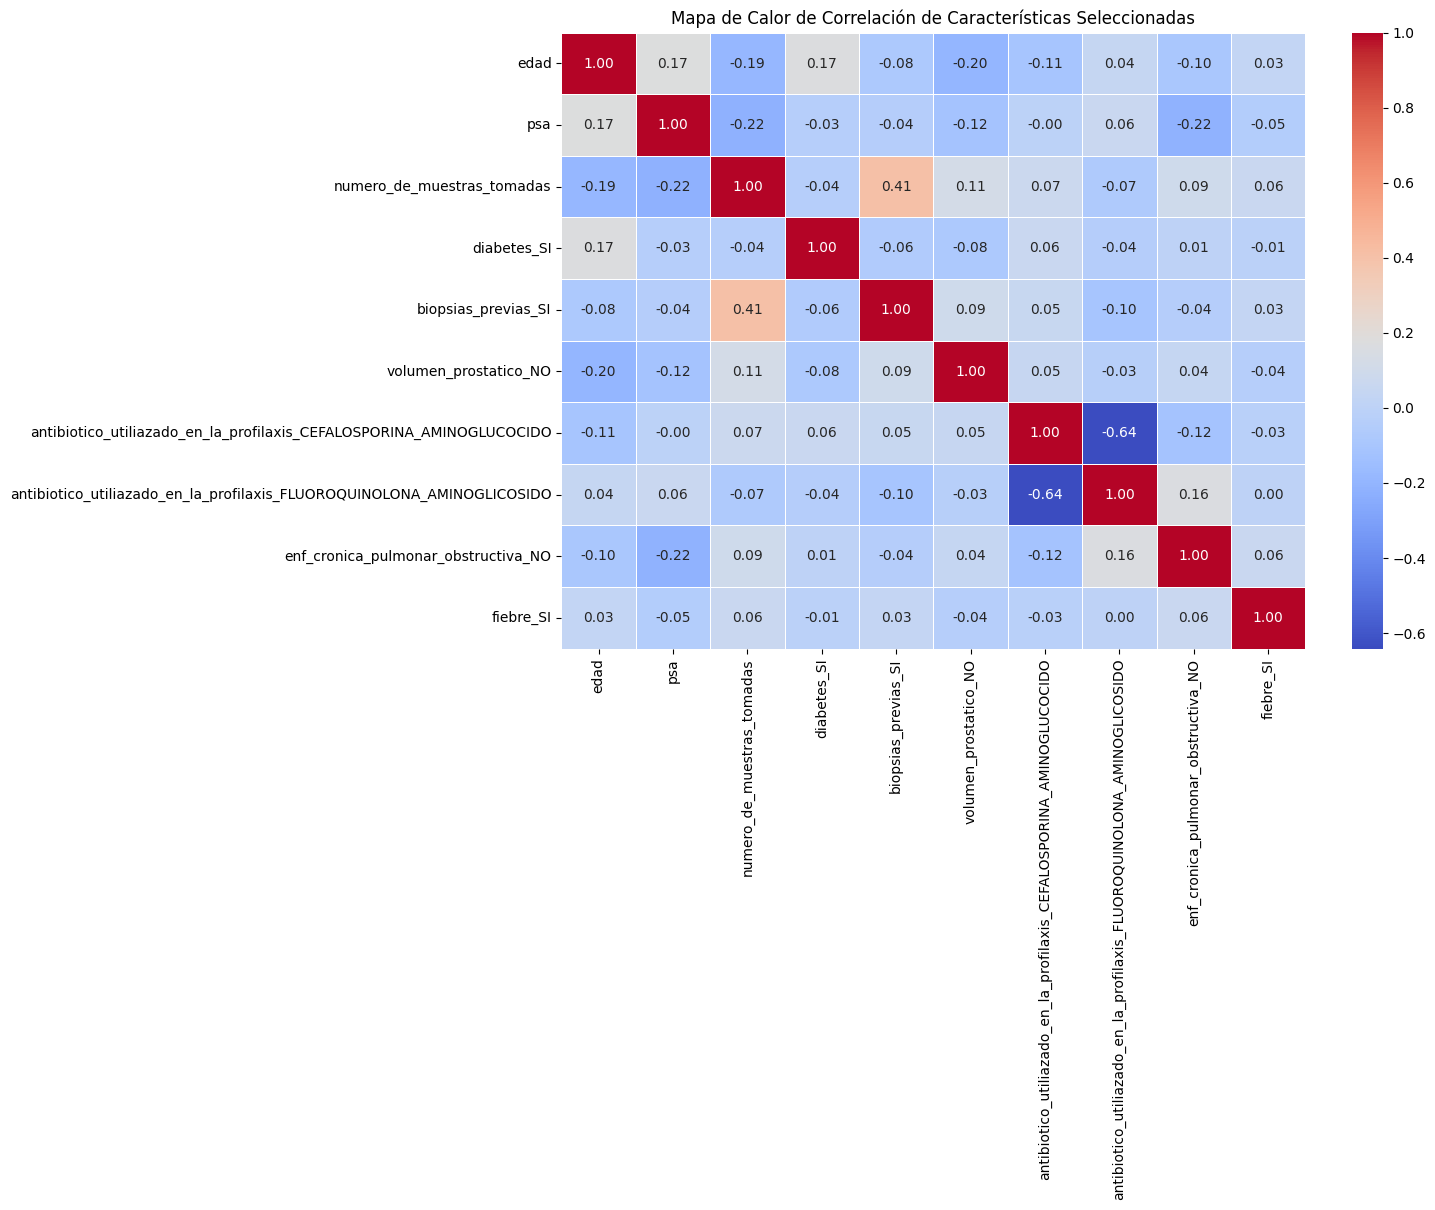

In [16]:
# Crear un DataFrame con las características seleccionadas
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns)

# Calcular la matriz de correlación
correlation_matrix = X_train_selected_df.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlación de Características Seleccionadas')
plt.show()

## Explore Data